In [1]:
import scanpy as sc
import mudata as mu
from pathlib import Path
import pandas as pd

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_mtx = Path(
    "/Users/giovanni.palla/Datasets/moscot/rawData_mouseStSt/countTable_mouseStSt"
)

In [4]:
from urllib.request import urlopen
from urllib.error import HTTPError
from zipfile import ZipFile
from typing import BinaryIO

import anndata
import pandas as pd
import numpy as np
from scipy import sparse


def read_mtx_from_stream(stream) -> sparse.csr_matrix:
    curline = stream.readline()
    while curline.startswith("%"):
        curline = stream.readline()
    n, m, _ = (int(x) for x in curline[:-1].split(" "))

    max_int32 = np.iinfo(np.int32).max
    if n > max_int32 or m > max_int32:
        coord_dtype = np.int64
    else:
        coord_dtype = np.int32

    data = pd.read_csv(
        stream,
        sep=r"\s+",
        header=None,
        dtype={0: coord_dtype, 1: coord_dtype, 2: np.float32},
    )
    mtx = sparse.csr_matrix((data[2], (data[1] - 1, data[0] - 1)), shape=(m, n))
    return mtx

In [5]:
mtx_data_info = path_mtx / "matrix.mtx"
with open(mtx_data_info, "r") as f:
    expr = read_mtx_from_stream(f)

In [13]:
barcodes = pd.read_csv(path_mtx / "barcodes.tsv.gz", header=None)
features = pd.read_csv(path_mtx / "features.tsv.gz", header=None)

In [19]:
from anndata import AnnData

adata = AnnData(
    expr,
    obs=pd.DataFrame(index=barcodes[0].values),
    var=pd.DataFrame(index=features[0].values),
)

In [21]:
adata.var

""
Xkr4
Gm1992
Gm37381
Rp1
Sox17
...
AC168977.1
AC149090.1
CAAA01118383.1
Vmn2r122


In [23]:
adata_orig = adata.copy()

In [22]:
clusters = pd.read_csv("/Users/giovanni.palla/Datasets/moscot/annot_mouseStStAll.csv")
clusters

,UMAP_1,UMAP_2,cluster,annot,sample,cell,digest,typeSample
0,10.199693,-7.500118,21,T cells,CISE12,AAACCTGAGTTCGCGC-1,exVivo,citeSeq
1,12.429611,-5.372781,11,T cells,CISE12,AAACCTGGTGAGGCTA-1,exVivo,citeSeq
2,14.550602,-2.247851,26,ILC1s,CISE12,AAACCTGTCGGTGTCG-1,exVivo,citeSeq
3,11.260082,-5.692209,11,T cells,CISE12,AAACGGGAGTACGCGA-1,exVivo,citeSeq
4,13.879457,-1.479918,26,ILC1s,CISE12,AAACGGGCAGTATGCT-1,exVivo,citeSeq
...,...,...,...,...,...,...,...,...
185889,7.300422,-5.189817,19,Neutrophils,CS16,TTCTTAGCACATAACC-46,exVivo,scRnaSeq
185890,5.629435,-6.119583,19,Neutrophils,CS16,TTGAACGAGTGAAGTT-46,exVivo,scRnaSeq
185891,6.191045,-5.096178,19,Neutrophils,CS16,TTGACTTTCCAATGGT-46,exVivo,scRnaSeq
185892,6.637616,-5.062717,19,Neutrophils,CS16,TTGTAGGTCACTCCTG-46,exVivo,scRnaSeq


In [25]:
adata = adata[clusters.cell].copy()

In [26]:
np.testing.assert_array_equal(adata.obs_names.values, clusters.cell.values)

In [31]:
for c in clusters.columns:
    if "UMAP" not in c:
        adata.obs[c] = clusters[c].values.copy()

In [32]:
adata.obs

,cluster,annot,sample,cell,digest,typeSample
AAACCTGAGTTCGCGC-1,21,T cells,CISE12,AAACCTGAGTTCGCGC-1,exVivo,citeSeq
AAACCTGGTGAGGCTA-1,11,T cells,CISE12,AAACCTGGTGAGGCTA-1,exVivo,citeSeq
AAACCTGTCGGTGTCG-1,26,ILC1s,CISE12,AAACCTGTCGGTGTCG-1,exVivo,citeSeq
AAACGGGAGTACGCGA-1,11,T cells,CISE12,AAACGGGAGTACGCGA-1,exVivo,citeSeq
AAACGGGCAGTATGCT-1,26,ILC1s,CISE12,AAACGGGCAGTATGCT-1,exVivo,citeSeq
...,...,...,...,...,...,...
TTCTTAGCACATAACC-46,19,Neutrophils,CS16,TTCTTAGCACATAACC-46,exVivo,scRnaSeq
TTGAACGAGTGAAGTT-46,19,Neutrophils,CS16,TTGAACGAGTGAAGTT-46,exVivo,scRnaSeq
TTGACTTTCCAATGGT-46,19,Neutrophils,CS16,TTGACTTTCCAATGGT-46,exVivo,scRnaSeq
TTGTAGGTCACTCCTG-46,19,Neutrophils,CS16,TTGTAGGTCACTCCTG-46,exVivo,scRnaSeq


In [36]:
adata.obsm["X_umap"] = clusters[["UMAP_1", "UMAP_2"]].to_numpy()

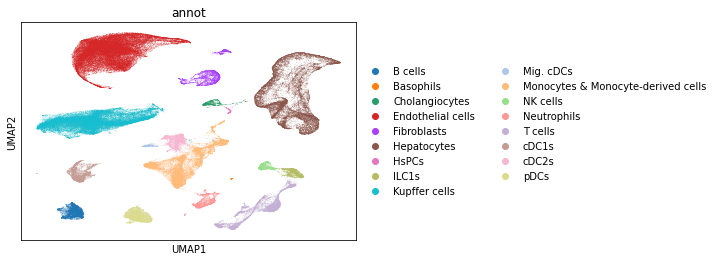

In [38]:
sc.pl.umap(adata, color="annot")

In [42]:
G = 5000
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.highly_variable_genes(adata, n_top_genes=G, layer="counts", flavor="seurat_v3")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [43]:
adata

AnnData object with n_obs × n_vars = 185894 × 22647
    obs: 'cluster', 'annot', 'sample', 'cell', 'digest', 'typeSample'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'sample_colors', 'annot_colors', 'hvg', 'log1p'
    obsm: 'X_umap'
    layers: 'counts'

In [44]:
path_mtx_ab = Path(
    "/Users/giovanni.palla/Datasets/moscot/rawData_mouseStSt/countTableADT_mouseStSt_overlapABs"
)
mtx_data_info = path_mtx_ab / "matrix.mtx"
with open(mtx_data_info, "r") as f:
    expr_ab = read_mtx_from_stream(f)

In [45]:
barcodes = pd.read_csv(path_mtx_ab / "barcodes.tsv.gz", header=None)
features = pd.read_csv(path_mtx_ab / "features.tsv.gz", header=None)

In [46]:
from anndata import AnnData

adata_ab = AnnData(
    expr_ab,
    obs=pd.DataFrame(index=barcodes[0].values),
    var=pd.DataFrame(index=features[0].values),
)

In [47]:
adata_ab

AnnData object with n_obs × n_vars = 181309 × 103

In [52]:
adata_ab = adata_ab[adata[adata.obs.typeSample == "citeSeq"].obs_names].copy()

In [53]:
path_save = Path("/Users/giovanni.palla/Datasets/moscot")
adata_ab.write(path_save / "adata_cite.h5ad")
adata.write(path_save / "adata_sc.h5ad")